In [28]:
#Music Genre Classifier: AML Group Project 2025
#CNN giving options for the user parameters and architecture choices

In [29]:
%pip install librosa
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import librosa
from glob import glob
from torch.utils.data import Dataset, DataLoader
import sklearn.metrics
import wandb

Note: you may need to restart the kernel to use updated packages.


In [30]:
%wandb login

In [31]:
def adjust_length(audio_data, target_length, iteration):
    if len(audio_data[iteration*target_length:]) < target_length:                                 #when remaining audio segment is shorter than target
        padding = target_length-len(audio_data[iteration*target_length:])                         #caclulated desired padding
        adjusted_audio = np.concatenate((audio_data[iteration*target_length:],np.zeros(padding))) #add padding to file
    elif len(audio_data) > target_length:                               #when audio segment is longer than target
        adjusted_audio = audio_data[iteration*target_length:(iteration+1)*target_length]                     #only take the portion of the audio up until the target
    else:                                                               #when audio is the target length
        adjusted_audio = audio_data                                     #keep the original audio and don't truncate or pad
                                                                        
    return adjusted_audio                                               #return the truncated or padded signal with the exact target length

In [32]:
def preprocess(audio_data, sample_rate, nfft):    
    max_value = np.max(np.abs(audio_data))  #calculate the maximum amplitude within the file
                                            
    if max_value > 0:                       #for files with audio
        normalised = audio_data/max_value   #divide so that the maximum amplitude is 1
    else:                                   #if audio is silent
        normalised = audio_data             #don't try to normalise it!

    spectrogram = librosa.feature.melspectrogram(y=normalised, sr=sample_rate, n_fft=nfft) #compute the spectrogram
    #spectrogram = librosa.feature.stft(y=normalised, n_fft=2048, hop_length=512) #short time fourier transform as an alternative feature
    zcr_feature = librosa.feature.zero_crossing_rate(y=normalised)  #zero crossing rate as secondary feature


    return spectrogram, zcr_feature                      #return the calculated features

In [33]:
#initalising files, features and labels list
train_files, val_files, test_files = [], [], []
train_features, val_features, test_features = [], [], []
train_labels, val_labels, test_labels = [], [], []


sr = 22050   #sample rate [Hz] as dataset specified
length = 30  #length of audio [s] as dataset specified
nfft = 2048  #fast fourier transform length

segmenting = 0  #0 => the code will take one piece of data per file
                #1 => the code will take len(data)/length segments per file (padding with zeros on last segment)
                #2 => the code will take len(data)/length segments per file (last segment will end before end of file data when possible)


#loading original data
for file in glob('genres_original/**/*.wav', recursive=True):
    file_name = file.split('/')[-1]

    if 'blues' in file_name:
        label = 0
    elif 'classical' in file_name:
        label = 1
    elif 'country' in file_name:
        label = 2
    elif 'disco' in file_name:
        label = 3
    elif 'hiphop' in file_name:
        label = 4
    elif 'jazz' in file_name:
        label = 5
    elif 'metal' in file_name:
        label = 6
    elif 'pop' in file_name:
        label = 7 
    elif 'reggae' in file_name:
        label = 8
    elif 'rock' in file_name:
        label = 9
    else:
        assert(f'{file} is the wrong format.')

    id = int(file_name.split('.')[1])


    train = True if id < 80 else False # Train/Validation/Test Split 80/10/10
    val = True if  80 <= id < 90 else False
    
    # Load Audio and append to train/validation/test list
    try:
        audio, fs = librosa.load(file)
        sourceLength = len(audio)                           #record full length of audio file
        if segmenting == 0:
            sections = int(1)
        elif segmenting == 1:
            sections = int(np.ceil(sourceLength/(length*sr)))
        elif segmenting == 2:
            sections = int(np.floor(sourceLength/(length*sr)))
        else:
            print("Bad input variable (segmenting != [0,1,2]")

        for i in range(sections):
            y_correct_length = adjust_length(audio,sr*length,i)                  #truncate or pad signals to desired length
            y_spectrogram, zcr_feature = preprocess(y_correct_length, sr, nfft)  #normalise audio data and extract features
            feature_1 = torch.from_numpy(y_spectrogram).float().squeeze(-1)      #add 1 dimension to start
            feature_2 = torch.from_numpy(zcr_feature).float().squeeze(-1)        #add 1 dimension to start
            feature = torch.cat((feature_1, feature_2), dim=0)                   #join the features into one feature vector

            #determine which set the data belongs too
            if train:
                train_files.append(file)
                train_features.append(feature)
                train_labels.append(label)
            elif val:
                val_files.append(file)
                val_features.append(feature)
                val_labels.append(label)
            else:
                test_files.append(audio)
                test_features.append(feature)
                test_labels.append(label)

    except Exception as e:
        print(f'Error{e}: {file} not loaded')   #management of corrupted files
    


train_features = torch.stack(train_features).float()    #convert list into float32 torch tensor
val_features = torch.stack(val_features).float()        #convert list into float32 torch tensor
test_features = torch.stack(test_features).float()      #convert list into float32 torch tensor

#Check: print length and size of training, validation and testing features
print(f"Train files: {len(train_files)}, Validation files: {len(val_files)}, Test files: {len(test_files)}")
print(f"Train Features: {len(train_features)}, Validation Features: {len(val_features)}, Test Features: {len(test_features)}")
print(f"Train Features Shape: {train_features.shape}, Validation Features Shape: {val_features.shape}, Test Features Shape: {test_features.shape}")

C:\Users\Shona\AppData\Local\Temp\ipykernel_31488\2378142581.py:51: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, fs = librosa.load(file)
C:\Users\Shona\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error: genres_original\jazz\jazz.00054.wav not loaded
Train files: 799, Validation files: 100, Test files: 100
Train Features: 799, Validation Features: 100, Test Features: 100
Train Features Shape: torch.Size([799, 129, 1292]), Validation Features Shape: torch.Size([100, 129, 1292]), Test Features Shape: torch.Size([100, 129, 1292])


In [34]:
#Defining Dataset classes for labelled and unlabelled data
class AudioDataSet(Dataset):
    def __init__(self, features, labels):
        self.features = (features)              #save features to class
        self.labels = (labels)                  #save labels to class
        
    def __getitem__(self, i):
        return self.features[i], self.labels[i] #return requested features and labels
 
    def __len__(self):
        return len(self.features)               #return length of features

class UnlabeledAudioDataSet(Dataset):
    def __init__(self, features):
        self.features = (features)              #save features to class
    def __getitem__(self, i):
        return self.features[i]                 #return requested features and labels
    def __len__(self):
        return len(self.features)               #return length of features

In [35]:
class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, activation):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size)   #1D convolution layer
        if activation == 1:
            self.act = nn.ReLU()                                        #non-linear activation function layer
        elif activation == 2:
            self.act = nn.Sigmoid()                                     #sigmoid activation function layer
        elif activation == 3:
            self.act = nn.Tanh()                                        #tanh activation function layer
        else:
            assert'Incorrect activation function index'
                                                           
    def forward(self, x):
        x = self.conv(x)                #apply 1d convolution layer
        x = self.act(x)                 #apply activation function layer
        return x                        #return the output from the block

In [36]:
class ConvNet(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, num_blocks, num_classes,activation,pool,dropout):
        super(ConvNet, self).__init__()
        self.conv_blocks = nn.ModuleList()              #initialise class variable for the network's structure
                                                                                                
        for block in range(num_blocks):
            self.conv_blocks.append(ConvBlock(in_channels,out_channels,kernel_size,activation)) #add the block to the architecture
            in_channels = out_channels                                                          #set the number of input channels for the next block to be the size of the output channels of current block

        self.dropout = nn.Dropout(p=dropout)                       #create dropout layer

        if pool == 1:
            self.pooling = nn.AdaptiveAvgPool1d(1)      #create global average pooling layer 
        elif pool == 2:
            self.pooling = nn.AdaptiveMaxPool1d(1)      #create global maximum pooling layer 
        else:
            assert'Incorrect pooling index'

        self.linear_layer = nn.Linear(out_channels,num_classes)    #create linear layer for output

    def forward(self, x):
        for conv_block in self.conv_blocks:
            x = conv_block(x)                           #apply convolutional block
            x = self.dropout(x)                         #apply dropout

        x = self.pooling(x)                             #apply global average pooling
        x = x.squeeze(-1)                               #remove extra dimension 
        x = self.linear_layer(x)                        #apply linear layer

        return x

In [37]:
def train_loop(model, train_loader, optimiser, CEloss, num_epochs):
    train_losses = []                                       #initialise training losses list
    
    for epoch in range(num_epochs):
        train_loss = 0.0                                    #initialise the training loss
        for batch in train_loader:
            features, labels = batch                        #find features and labels in batch
            features = features.squeeze(1)                  #remove extra dimension
            optimiser.zero_grad()                           #zero gradient optimiser
            
            output = model(features)                        #compute model's predictions
            loss = CEloss(output, labels)                  #calculate training loss
            
            loss.backward()                                 #backward propagation
            optimiser.step()                                #update the NN's parameters
            train_loss += loss.item()                       #add the iteration's loss to a counter
                                                            
        avg_loss = train_loss/len(train_loader)             #calculate average loss

        print(f"Epoch {epoch+1}/{num_epochs}")
        if epoch % 5 == 0:                                  #every five epochs calls validation loop
            validate_loop(model, val_loader, CEloss)

        wandb.log({"Epoch: ": epoch, "Training Loss: ": avg_loss})  #logging epoch and training loss on Wandb
        train_losses.append(avg_loss)                               #add average loss to list

In [38]:
def validate_loop(model, val_loader, CEloss):
    model.eval()                                             #set model to evaluation mode
    val_losses, val_accs = [], []                            #initialise lists for validation losses and validation accuracies
    correct_pred, total_pred = 0, 0                          #initialise counter for total predictions and amount of correct predictions

    with torch.no_grad():
        for epoch in range(0, num_epochs, 5):                    #for every 5 iterations
            val_loss = 0.0                                       #initialise validation loss
    
            for batch in val_loader:      
                features, labels = batch                         #find features and labels in batch
                features = features.squeeze(1)                   #remove extra dimension
                
                output = model(features)                         #compute model's predictions
                loss = CEloss(output, labels)                   #calculate validation loss
                val_loss += loss.item()                          #add validation loss list with loss
        
                _, pred = torch.max(output, 1)                   #pred = index of the features maximum (class labels), ignoring maximum value (_)
                correct_pred += (pred == labels).sum().item()    #add to counter if the prediction is equal to the label
                total_pred += labels.size(0)                     #add to counter of total predictions
    
        avg_loss = val_loss/len(val_loader)              #calculate average loss
        acc = correct_pred/total_pred                    #calculate accuracy  
            
        val_losses.append(avg_loss)                      #add average loss to the validation loss list
        val_accs.append(acc*100)                         #add accuracy to the validation accuracy list

        #Output: print overall accuracy and loss from testing set, and log on Wandb
        print(f'Validation loss: {avg_loss:.3f}, Validation Accuracy: {acc*100:.1f}%')
        wandb.log({"Validation Loss": avg_loss, "Validation Accuracy": acc*100})

In [39]:
def test_loop(model, test_loader, CEloss):
    model.eval()                                             #set model to evaluation mode
    test_loss = 0.0                                          #initialise test loss
    correct_pred, total_pred = 0, 0                          #initialise counter for total predictions and amount of correct predictions
    test_labels, test_preds = [], []                         #initialise lists for test labels and test predictions

    with torch.no_grad():
        for batch in test_loader:
            features, labels = batch                             #find features and labels in batch
            features = features.squeeze(1)                       #remove extra dimension
            
            output = model(features)                             #compute model's predictions
            loss = CEloss(output, labels)                       #calculate test loss
            test_loss += loss.item()                             #add test loss list with loss
    
            _, pred = torch.max(output, 1)                       #pred = index of the features maximum (class labels), ignoring maximum value (_)
            correct_pred += (pred == labels).sum().item()        #add to counter if the prediction is equal to the label
            total_pred += labels.size(0)                         #add to counter of total predictions
    
            test_labels.extend(labels.numpy())                   #add correct predictions to list
            test_preds.extend(pred.numpy())                      #add model predictions to list 
            
    avg_loss = test_loss/len(test_loader)                #calculate average loss
    acc = correct_pred/total_pred                        #calculate accuracy  

    #Output: print overall accuracy and loss from testing set, and log on Wandb
    print(f'Testing loss: {avg_loss:.3f}, Testing Accuracy: {acc*100:.1f}%')
    wandb.log({"Test Accuracy" : acc*100})
    return test_labels, test_preds

In [40]:
#Loop for processing of unlabelled data!
def prediction_loop(model, unlabeled_loader):
    model.eval()                            #set model to evaluation mode
    unlabeled_predictions = []              #initalise list for predicted labels
    with torch.no_grad():
        for features in unlabeled_loader:
            features = features.squeeze(1)  #remove extra dimension

            output = model(features)        #compute model's predictions
            _, pred = torch.max(output, 1)  #pred = index of the features maximum (class labels), ignoring maximum value (_)

            unlabeled_predictions.extend(pred.numpy())  #add predictions to the list
    return np.array(unlabeled_predictions)


In [41]:
#User defined parameters
num_blocks = 4          #number of blocks
kernel_size = 3         #number of kernels
num_epochs = 125        #number of epochs
num_classes = 10        #number of classes
activation = 3          #1:ReLU    2:Sigmoid    3:Tanh
pool = 1                #1:Average 2:Maximum
optimiser = 1           #1:Adam    2:SGD
dropout = 0.25          #dropout rate
learning_rate = 0.001   #learning rate
batch_size = 50         #batch size

train_dataset = AudioDataSet(train_features, train_labels)                      #create training dataset and labels
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)   #load training dataset in batches of 50 samples
                                                                        
val_dataset = AudioDataSet(val_features, val_labels)                            #create validation dataset and labels
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)      #load validation dataset in batches of 50 samples

test_dataset = AudioDataSet(test_features, test_labels)                         #create test dataset and labels
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)    #load test dataset in batches of 50 samples

#Creating model
model = ConvNet(in_channels=129, out_channels=16, kernel_size=kernel_size, num_blocks=num_blocks, num_classes=num_classes, activation=activation, pool=pool, dropout=dropout)


if optimiser == 1:
    optimiser = torch.optim.Adam(model.parameters(),lr=learning_rate)                   #create instance of Adam optimiser
    func3 = "Adam"
elif optimiser == 2:
    optimiser = torch.optim.SGD(model.parameters())                    #create instance of SGD optimiser
    func3 = "SGD"
else:
    assert'Incorrect optimiser index'

CEloss = nn.CrossEntropyLoss()                                         #create instance of Cross Entropy loss

#Naming activation function for use in data collection
if activation == 1:
    func = "ReLU"
elif activation == 2:
    func = "Sigmoid"
elif activation == 3:
    func = "Tanh"

#Naming pooling type for use in data collection
if pool == 1:
    func2 = "Average"
elif pool == 2:
    func2 = "Maximum"
    
print(f"Model training with: {num_blocks} blocks, {func} Activation, Adaptive {func2} Pooling and {func3} Optimiser for {num_epochs} epochs and {kernel_size} kernels.")

#Passing to Wandb
my_config = {"Number of blocks" : num_blocks, "Activation" : activation, "Optimiser" : optimiser, "Pooling" : pool, "Number of epochs" : num_epochs, "Number of kernels" : kernel_size, "Dropout Rate" : dropout}


wandb.init(
    project="Genre_classifier",
    entity="jazz-54-hate-club",
    reinit=True,
    config=my_config,
    name=(f"GroupCompiledCode_{num_epochs}Epochs_{learning_rate}_{num_blocks}Blocks")
)


train_loop(model, train_loader, optimiser, CEloss, num_epochs)         #run training loop
test_labels, test_preds = test_loop(model, test_loader, CEloss)        #run testing loop


Model training with: 4 blocks, Tanh Activation, Adaptive Average Pooling and Adam Optimiser for 125 epochs and 3 kernels.


Epoch:,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
Test Accuracy,▁
Training Loss:,█▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▃▄▅▆▆▆▆▇▇▇▇▇█▇▇▇▇▇▇▇▇█▇▇
Validation Loss,█▆▅▄▃▃▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▂▂▁
Epoch:,124
Test Accuracy,58.0
Training Loss:,0.65811
Validation Accuracy,51
Validation Loss,1.53343


Epoch 1/125
Validation loss: 2.278, Validation Accuracy: 12.0%
Epoch 2/125
Epoch 3/125
Epoch 4/125
Epoch 5/125
Epoch 6/125
Validation loss: 1.996, Validation Accuracy: 34.0%
Epoch 7/125
Epoch 8/125
Epoch 9/125
Epoch 10/125
Epoch 11/125
Validation loss: 1.907, Validation Accuracy: 38.0%
Epoch 12/125
Epoch 13/125
Epoch 14/125
Epoch 15/125
Epoch 16/125
Validation loss: 1.827, Validation Accuracy: 34.0%
Epoch 17/125
Epoch 18/125
Epoch 19/125
Epoch 20/125
Epoch 21/125
Validation loss: 1.771, Validation Accuracy: 39.0%
Epoch 22/125
Epoch 23/125
Epoch 24/125
Epoch 25/125
Epoch 26/125
Validation loss: 1.725, Validation Accuracy: 38.0%
Epoch 27/125
Epoch 28/125
Epoch 29/125
Epoch 30/125
Epoch 31/125
Validation loss: 1.669, Validation Accuracy: 42.0%
Epoch 32/125
Epoch 33/125
Epoch 34/125
Epoch 35/125
Epoch 36/125
Validation loss: 1.656, Validation Accuracy: 44.0%
Epoch 37/125
Epoch 38/125
Epoch 39/125
Epoch 40/125
Epoch 41/125
Validation loss: 1.656, Validation Accuracy: 35.0%
Epoch 42/125
Epoc

In [42]:
#Evaluation of audio files outwith dataset

different_test_names, different_test_files, different_test_features = [], [], []

unlabeled_sr = 48000    # sample rate [Hz]
unlabeled_length = 90   # duration used [s]
unlabeled_section = 0   # section used [0 => 0-length seconds, 1 => length-2*length seconds]


#Process the audio files from outwith the dataset
for file in glob('other_audio/**/*.mp3', recursive=True): #loading in different audio files
    try:
        audio, fs = librosa.load(file)
        y_correct_length = adjust_length(audio, unlabeled_sr * unlabeled_length, unlabeled_section) #truncate or pad signals to desired length
        y_spectrogram, zcr_feature = preprocess(y_correct_length, sr, nfft)  #normalise audio data and extract features
        feature_1 = torch.from_numpy(y_spectrogram).float().squeeze(-1)      #add 1 dimension to start
        feature_2 = torch.from_numpy(zcr_feature).float().squeeze(-1)        #add 1 dimension to start
        feature = torch.cat((feature_1, feature_2), dim=0)                   #join the features into one feature vector

        #add unlabeled data to lists
        different_test_files.append(audio)
        different_test_features.append(feature)
        different_test_names.append(file)

    except Exception as e:
        print(f'Error{e}: {file} not loaded from other audio folder')

different_test_features = torch.stack(different_test_features).float() #convert list into float32 torch tensor

unlabeled_test_dataset = UnlabeledAudioDataSet(different_test_features) #create different test dataset with features
unlabeled_test_loader = DataLoader(unlabeled_test_dataset, batch_size=50) #create different test loader

predictions_unlabeled = prediction_loop(model, unlabeled_test_loader)   #run prediction loop

In [43]:
genres = ["Blues", "Clas", "Coun", "Disc", "HipH", "Jazz", "Meta", "Pop", "Regg", "Rock"]
predicted_string_labels = [genres[label] for label in predictions_unlabeled] #converting number label to string label

print("Predicted genres:")
for track, genre in zip(different_test_names, predicted_string_labels):     #takes file name and assosiacted genre
    print(f"{track}: {genre}")

Predicted genres:
other_audio\01 Double-F the King - Missing My Babygirl.mp3: Pop
other_audio\02 Double-F the King - Be My Girl.mp3: Pop
other_audio\03 Double-F the King - For You.mp3: Disc
other_audio\04 Double-F the King - Your Blessing.mp3: Pop
other_audio\05 Double-F the King - Can't Get Enough.mp3: Pop


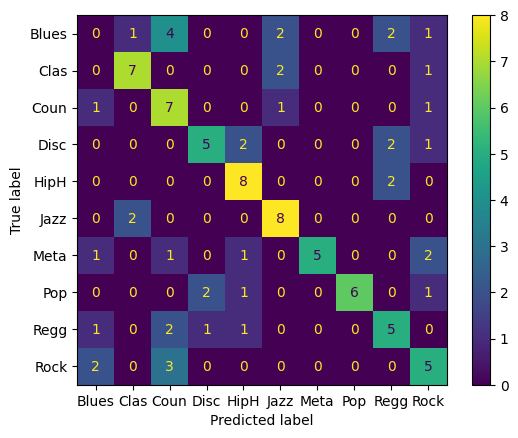

In [44]:
matrix = sklearn.metrics.confusion_matrix(test_labels,test_preds)   #create confusion matrix using testing dataset
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=genres)                            #add matrix to displayable plot variable

#Output: display confusion matrix and save figure to Wandb
disp.plot()
plt.savefig(f'CM_model_{num_blocks}_{func}_{func2}_{func3}_{num_epochs}_{kernel_size}.png')

matrix_save = wandb.plot.confusion_matrix(y_true=test_labels, preds=test_preds, class_names=genres)
wandb.log({"Confusion Matrix": matrix_save})

In [45]:
#Classification Report
report = sklearn.metrics.classification_report(test_labels,test_preds, target_names=genres)
print(report)

report_columns =  ["Class", "Precision", "Recall", "F1-score", "Support"]
class_report = report.splitlines()

report_table = []
for line in class_report[2:(len(genres)+2)]:
    report_table.append(line.split())

wandb.log({"Classification Report": wandb.Table(data=report_table, columns=report_columns)})

              precision    recall  f1-score   support

       Blues       0.00      0.00      0.00        10
        Clas       0.70      0.70      0.70        10
        Coun       0.41      0.70      0.52        10
        Disc       0.62      0.50      0.56        10
        HipH       0.62      0.80      0.70        10
        Jazz       0.62      0.80      0.70        10
        Meta       1.00      0.50      0.67        10
         Pop       1.00      0.60      0.75        10
        Regg       0.45      0.50      0.48        10
        Rock       0.42      0.50      0.45        10

    accuracy                           0.56       100
   macro avg       0.58      0.56      0.55       100
weighted avg       0.58      0.56      0.55       100

